In [143]:
"""
Import all the required libraries.
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import pydot
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import sys
import glob

"""
The Graph Class
"""
class Graph:
    def __init__(self):
        # Dictionary containing keys that map to the corresponding vertex
        # object.
        self.vertices = {}
        
    def addVertex(self, key):
        # Add a vertex with the given key to the graph.
        vertex = Vertex(key)
        self.vertices[key] = vertex
        
    def getVertex(self, key):
        # Return vertex object with the corresponding key.
        return self.vertices[key]
    
    def __contains__(self, key):
        return key in self.vertices
    
    def addEdge(self, src_key, dest_key, weight=1):
        # Add edge from src_key to dest_key with given weight.
        self.vertices[src_key].addNeighbor(self.vertices[dest_key], weight)
        
    def doesEdgeExist(self, src_key, dest_key):
        # Return True if there is an edge from the given source and destination
        # key pair.
        return self.vertices[src_key].doesPointTo(self.vertices[dest_key])
    
    def __iter__(self):
        return iter(self.vertices.values())

"""
The Vertex Class
"""

class Vertex:
    def __init__(self, key):
        self.key = key
        self.points_to = {}
        self.gene_copy_number = np.zeros(8)
        self.label = np.zeros(9)
    
    # def __init__(self):
    #     self.gene_copy_number = np.zeros(8)
        
    def getKey(self):
        # Return the key corresponding to this vertex object.
        return self.key
    
    def addNeighbor(self, dest, weight):
        # Make this vertex point to dest with given edge weight.
        self.points_to[dest] = weight
        
    def getNeighbors(self):
        # Return all vertices pointed to by this vertex.
        return self.points_to.keys()
    
    def getWeight(self, dest):
        # Get weight of edge from this vertex to dest.
        return self.points_to[dest]
    
    def doesPointTo(self, dest):
        # Return True if this vertex points to dest.
        return dest in self.points_to

    def addGeneCopyNumber(self, gcn):
        self.gene_copy_number = gcn
    
    def addLabel(self, label):
        self.label = label

    def getGeneCopyNumber(self):
        return self.gene_copy_number
    
    def getGeneLabel(self):
        return self.label

"""
The Queue Class
"""

class Queue:
    def __init__(self):
        self.items = []
        
    def isEmpty(self):
        return self.items == []
    
    def enqueue(self, data):
        self.items.append(data)
        
    def dequeue(self):
        return self.items.pop(0)

file_list = glob.glob("/Users/xinli/Dropbox/BE562_Computational_Biology/Project/CodeRepository/Data_Preprocessing/patient_data_by_category/IDC/*_IDC.txt")
PATIENT = 12
print(file_list[PATIENT])
data = np.loadtxt(file_list[PATIENT], skiprows=1)

g = Graph()

num_vertices = len(data)

for idx in range(num_vertices):
    # print(row)
    g.addVertex(idx)
    vertex = g.getVertex(idx)
    vertex.addGeneCopyNumber(data[idx][-9:-1].astype(int))
    vertex.addLabel(data[idx][-9:].astype(int))

for i in range(num_vertices):
    vertex = g.getVertex(i)

copy_number_array = np.empty([num_vertices,8]).astype(int)
label_array = np.empty([num_vertices,9]).astype(int)

for i in range(num_vertices):
    vertex = g.getVertex(i)
    copy_number_array[i] = vertex.getGeneCopyNumber().astype(int)
    label_array[i] = vertex.getGeneLabel().astype(int)

manhattan_distance_matrix = np.empty([num_vertices, num_vertices]).astype(int)

for i in range(num_vertices):
    for j in range(num_vertices):
        manhattan_distance_matrix[i][j] = sum(abs(np.subtract(copy_number_array[i],
        copy_number_array[j]))).astype(int)

copy_number_df = pd.DataFrame(copy_number_array, index = range(num_vertices))
manhattan_df = pd.DataFrame(manhattan_distance_matrix, index = range(num_vertices),
                           columns = range(num_vertices))

/Users/xinli/Dropbox/BE562_Computational_Biology/Project/CodeRepository/Data_Preprocessing/patient_data_by_category/IDC/P_B2_IDC.txt


In [144]:
def locateMin(a):
    smallest = min(a)
    return smallest, [index for index, element in enumerate(a) if smallest == element]

def without(iterable, remove_indices):
    """
    Returns an iterable for a collection or iterable, which returns all items except the
    specified indices.
    """
    if not hasattr(remove_indices, '__iter__'):
        remove_indices = {remove_indices}
    else:
        remove_indices = set(remove_indices)
    for k, item in enumerate(iterable):
        if k in remove_indices:
            continue
        yield item

def graphGenerator(DG, vertex_idx):
    visited = set()
    q = Queue()
    q.enqueue(vertex_idx)
    visited.add(vertex_idx)
    
    while not q.isEmpty():
        current = q.dequeue()
            
        for leaf in list(without(range(num_vertices),visited)):
            if leaf != 0 and sum(copy_number_array[current,:]==
                                 copy_number_array[leaf,:]) > 6 and manhattan_distance_matrix[current,leaf] <= 4:
                DG.add_weighted_edges_from([(current, leaf,
                                             manhattan_distance_matrix[current,leaf])])
                visited.add(leaf)
                q.enqueue(leaf)

def bfs(DG, vertex_idx):
    visited = set()
    q = Queue()
    q.enqueue(vertex_idx)
    visited.add(vertex_idx)
    
    while not q.isEmpty():
        current = q.dequeue()
            
        for leaf in list(without(range(num_vertices),visited)):
            if leaf != 0 and manhattan_distance_matrix[ROOT,leaf] < manhattan_distance_matrix[ROOT,current] + 4:
                DG.add_weighted_edges_from([(current, leaf,
                                             manhattan_distance_matrix[current,leaf])])
                visited.add(leaf)
                q.enqueue(leaf)
                
def addMonotonePath(DG, src, sink):
    for i in list(without(range(num_vertices), src)):
        if src != sink:
            if manhattan_distance_matrix[ROOT,src] <= manhattan_distance_matrix[ROOT,i] and manhattan_distance_matrix[ROOT,i] < manhattan_distance_matrix[ROOT,sink]:
                DG.add_weighted_edges_from([(src,i,manhattan_distance_matrix[src,i])])
                src = i

DG =nx.DiGraph()
DG.add_nodes_from(range(num_vertices))
ROOT = 0
traversed = []
THRESHOLD = np.max(manhattan_distance_matrix) // 2

graphGenerator(DG, ROOT)

for i in range(1,num_vertices):
    graphGenerator(DG,i)
    addMonotonePath(DG,ROOT,i)

for i in range(1,num_vertices):
    if DG.degree[i] == 0:
        for j in range(num_vertices):
                if j != 0:
                    DG.add_weighted_edges_from([(i,j,manhattan_distance_matrix[i,j])])
                DG.add_weighted_edges_from([(j,i,manhattan_distance_matrix[j,i])])

node_dict = {}

pos = graphviz_layout(DG, prog='dot')
for i in range(num_vertices):
    label_firstline = ' '.join(str(f) for f in label_array[i,:4])
    label_secondline = ' '.join(str(s) for s in label_array[i,4:-1])
    node_dict[i] = label_firstline+'\n'+label_secondline + '\n====\n' + str(label_array[i,-1])

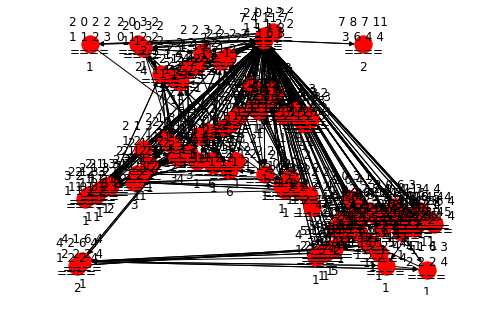

In [145]:
nx.draw(DG, pos, labels=node_dict, arrows=True)
plt.show()

write_dot(DG,'debug.dot')
!dot -T png debug.dot > DEBUG.png

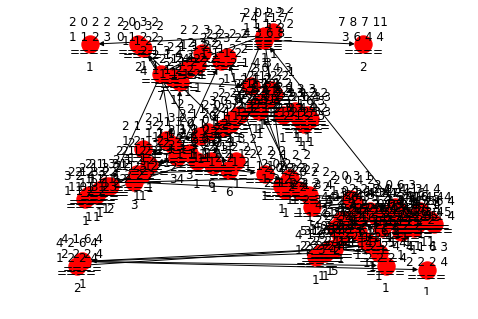

In [146]:
branching = nx.tree.minimum_spanning_arborescence(DG, attr="weight")
pos_branching = graphviz_layout(branching, prog='dot')
nx.draw(branching, pos, labels=node_dict, arrows=True)
H = nx.relabel_nodes(branching, node_dict, copy=False)
write_dot(H,'test.dot')
!dot -T png test.dot > IDC_MinCost_Arborescence_Patient2.png

In [147]:
filename = "IDC_2" + ".txt"
file = open(filename, "w")
edge_list = list(H.edges)

for i in range(len(edge_list)):
    nodes = list(edge_list[i])
    start = nodes[0][0:7] + ' ' + nodes[0][8:15] + ' ' + str(int(nodes[0][-2:]))
    end = nodes[1][0:7] + ' ' + nodes[1][8:15] + ' ' + str(int(nodes[1][-2:]))
    row = np.zeros([8])

    for j in range(15):
        cnt = 0
        if start[j] != end[j]:
            if start[j] != '\n' and end[j] != '\n' and start[j] != '=' and end[j] != '=':
                row[j // 2] = 1
    line_to_write = str(start) + ' ' + str(end) + ' ' + str(row.astype(int)) + ' ' + str(sum(row.astype(int))) + '\n'
    file.write(line_to_write)

file.close()

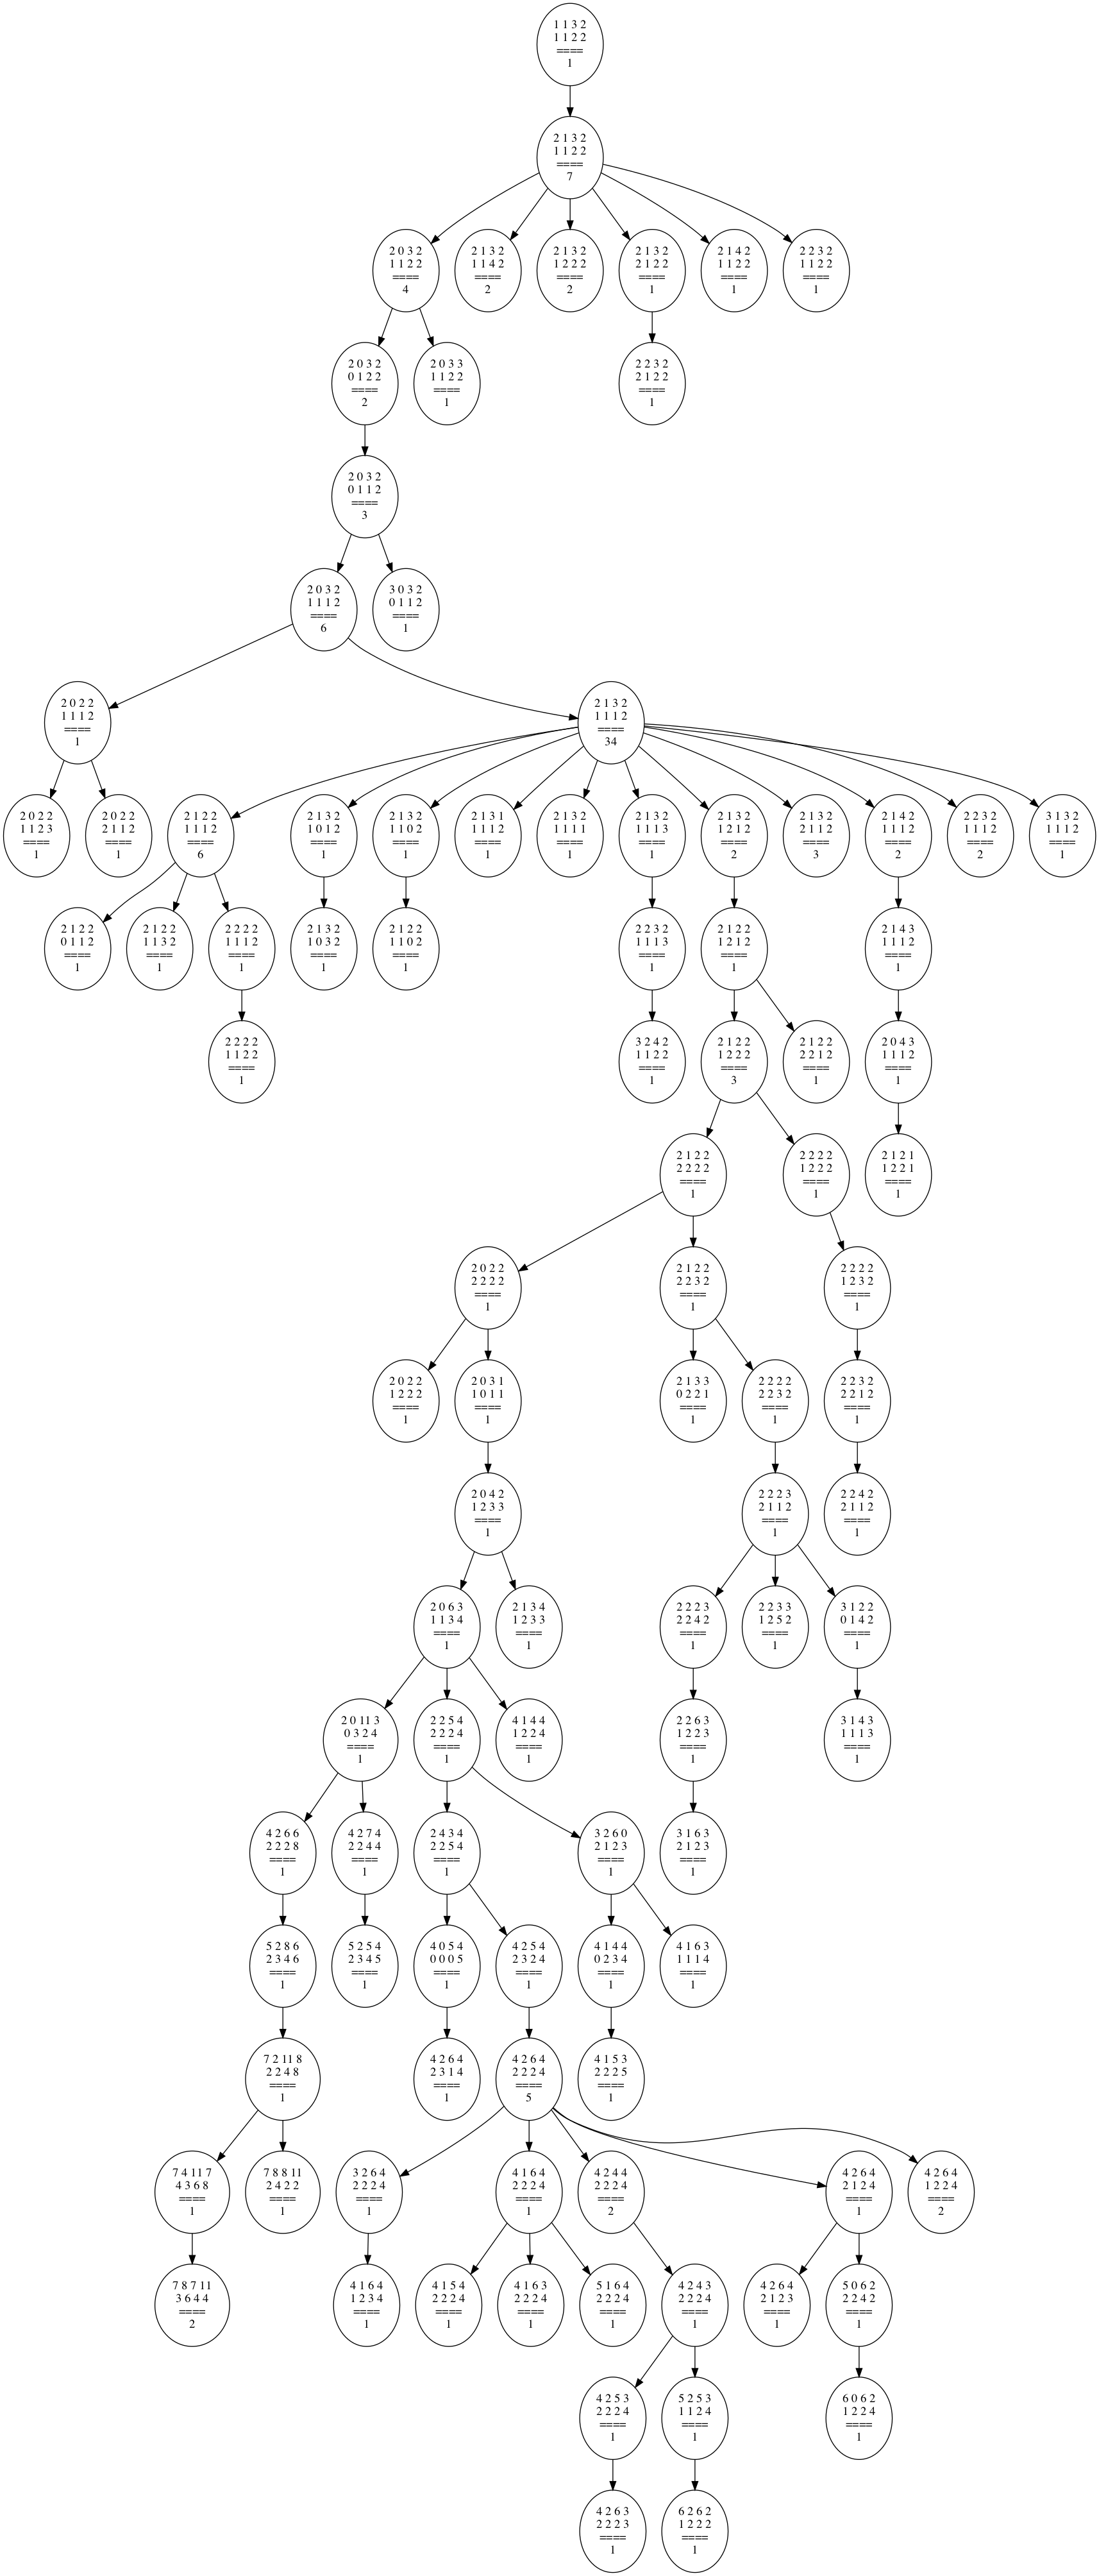

In [1]:
from IPython.display import Image

Image(filename='IDC_MinCost_Arborescence_Patient2.png') 